In [ ]:
# CS 8803 Efficient Machine Learning
# Nandan Bharatkumar Parikh
# GT ID: 903487850
# Date: 09/29/2025

# Lab 01: Pruning

# [40%] Task 01: Basic Pruning Techniques and Observations

In this section, we will explore neural network pruning using PyTorch to understand how removing parameters affects model performance and efficiency. Pruning is a model compression technique that removes unnecessary weights or neurons from trained neural networks while attempting to maintain accuracy. We will use [PyTorch's pruning library](https://pytorch.org/tutorials/intermediate/pruning_tutorial.html) to implement various pruning strategies.

## What is Pruning?

Neural network pruning systematically removes weights, neurons, or entire layers from a trained model to reduce computational complexity and memory requirements. The key insight is that many neural networks are over-parameterized, containing redundant connections that can be eliminated without significantly impacting performance.

This section is worth **40%** of the total lab grade.

---

## Task Overview

Complete the following tasks in order:

1. **Download and visualize a dataset** - Load and explore the dataset characteristics
2. **Train a model from scratch** - Implement and train a baseline neural network
3. **Evaluate the baseline model** - Measure accuracy, model size, and inference time
4. **Apply pruning techniques** - Implement magnitude-based pruning with different sparsity levels
5. **Analyze pruning sensitivity** - Visualize how different layers respond to pruning
6. **Compare performance trade-offs** - Document accuracy vs. compression relationships
7. **Reflection and analysis** - Explain your observations and lessons learned

**Deliverables:** Code implementation, visualization plots, performance analysis, and written explanations for each task.

### [5%] Part a: Download the dataset and view an image.
Using torch vision, download the CIFAR10 dataset into the Google Colab.
Create a train and test set. In torchvision you can do this by doing:

```
torchvision.datasets.DATASET(root='./data',train=[true/false],download=True)
```
You do not need to add transformations.

Then, write a function to show an image from each class. The final result should look something like this:

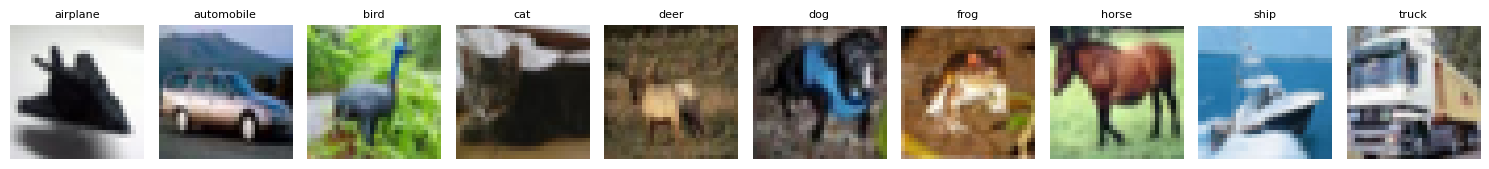


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import math
import numpy as np
from torch.nn.utils import prune

In [ ]:
#####
# Write your code here to download the CIAR10 dataset.
#
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
batch_size = 64

train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)
#

100%|██████████| 170M/170M [00:04<00:00, 42.5MB/s]


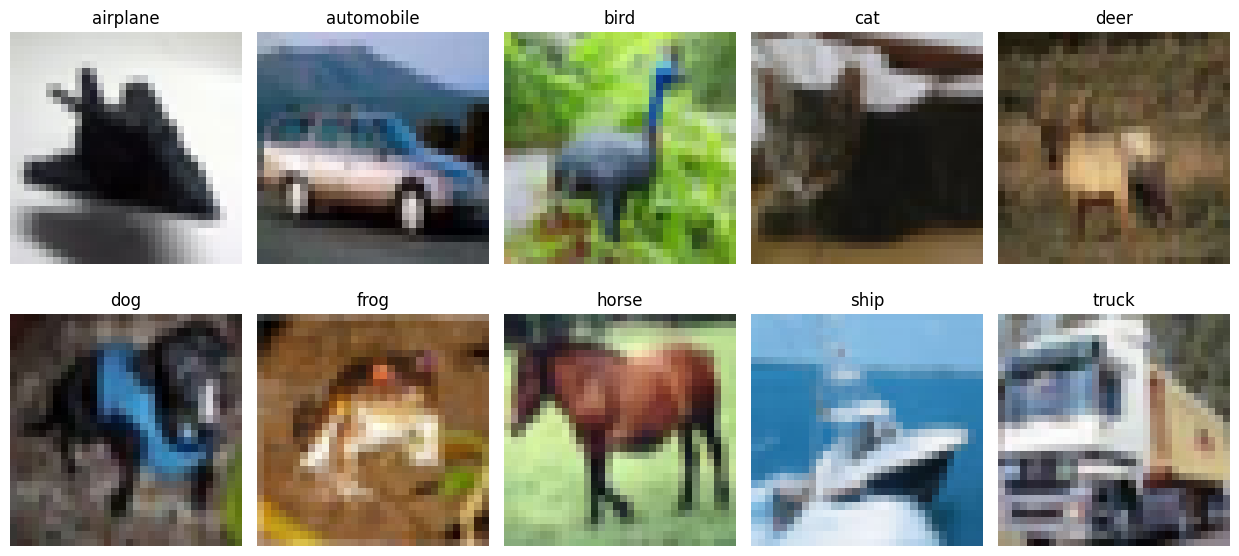

In [ ]:
2####
# Write your code here to visualize all 10 classes from CIFAR10.
#

def show_one_image_per_class(dataset):
    # --- 1. Find one image for each class ---
    class_names = dataset.dataset.classes
    num_classes = len(class_names)
    class_images = {}

    for images, labels in dataset:
        for i in range(len(labels)):
            label = labels[i].item()
            # Store the first image found for a class
            if label not in class_images:
                class_images[label] = images[i]
            # Stop when we have one for each class
            if len(class_images) == num_classes:
                break
        if len(class_images) == num_classes:
            break

    # --- 2. Display the images ---
    if not class_images:
        print("Could not find any images.")
        return

    # Sort images by class index for a consistent plot order
    sorted_images = dict(sorted(class_images.items()))

    # Create a figure and a set of subplots
    cols = 5
    rows = math.ceil(num_classes / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 3))
    axes = axes.flatten()

    for i, (class_idx, image_tensor) in enumerate(sorted_images.items()):
        ax = axes[i]

        # Un-normalize from [-1, 1] to [0, 1] for displaying
        img = image_tensor / 2 + 0.5
        np_img = img.numpy()

        # Transpose from (C, H, W) to (H, W, C) for matplotlib
        ax.imshow(np.transpose(np_img, (1, 2, 0)))

        ax.set_title(class_names[class_idx])
        ax.axis('off')

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

show_one_image_per_class(train_loader)

### [10%] Part b: Train a Neural Network, Count Parameters, and Evaluate

#### [5%] Training a ResNet Model for CIFAR-10

Using the provided network definition below, create a ResNet architecture configured for the CIFAR-10 dataset. You will need to:

1. **Configure the model architecture**:
  - Set the number of input channels to match CIFAR-10 images (3 RGB channels)
  - Set the number of output classes to match CIFAR-10 labels (10 classes)

2. **Train the model**:
  - Use the provided training code
  - Train for exactly **10 epochs**
  - Monitor training progress and loss

3. **Evaluate model performance**:
  - Test the trained model on the CIFAR-10 test set
  - Record the final accuracy

**Expected Results**: You should achieve approximately **85% accuracy**. Minor variations (±2-3%) are normal and acceptable. The goal is to understand the pruning process, not to create a state-of-the-art classifier.

#### [5%] Parameter Analysis

After training, analyze your model's structure by counting the parameters in each module:

1. **Count total parameters** in the entire model
2. **Count parameters by layer type** (convolutional layers, batch normalization, fully connected layers)
3. **Create a summary table** showing parameter distribution across the network
4. **Identify the most parameter-heavy modules**

This analysis will help you understand which parts of the network are most affected by pruning in the next section.

---

In [ ]:
# Model definition, DO NOT CHANGE
# You will be training this model.

def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

# Model definition, DO NOT CHANGE
# You will be training this model.

In [ ]:
####
# Your model definition
#
# You need to finish this one.
model = ResNet9(in_channels=3, num_classes=len(train_loader.dataset.classes))

In [ ]:
# Training code for model
# Complete the training loop where it says to modify.

def train(model, train_loader, num_epochs, lr=1e-3, weight_decay=1e-4):
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
    criterion = nn.CrossEntropyLoss()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    size = len(train_loader.dataset)
    model = model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for batch_idx, (data, target) in enumerate(train_loader):
          data, target = data.to(device), target.to(device)
          pred = model(data)

          optimizer.zero_grad()
          loss = criterion(pred, target)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()


        # IMPORTANT: You need to finish this.
        # Complete training loop here


        print(f"Epoch [{epoch+1:3d}] | Train Loss: {running_loss / len(train_loader):.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")


In [ ]:
####
# Train the model.
#
# You need to finish this one.
train(model=model, train_loader=train_loader, num_epochs=10)

Epoch [  1] | Train Loss: 1.0542 | LR: 0.001000
Epoch [  2] | Train Loss: 0.6014 | LR: 0.001000
Epoch [  3] | Train Loss: 0.4203 | LR: 0.001000
Epoch [  4] | Train Loss: 0.2963 | LR: 0.001000
Epoch [  5] | Train Loss: 0.2165 | LR: 0.001000
Epoch [  6] | Train Loss: 0.1781 | LR: 0.001000
Epoch [  7] | Train Loss: 0.1416 | LR: 0.001000
Epoch [  8] | Train Loss: 0.1017 | LR: 0.001000
Epoch [  9] | Train Loss: 0.0647 | LR: 0.001000
Epoch [ 10] | Train Loss: 0.0498 | LR: 0.001000


In [ ]:
####
# Evaluate the model.
#
# You need to finish this one.

def evaluate_test(model,dataloader):
  # you write this
  # need to return test loss and accuracy
  # use cross-entropy loss
  # be sure to have torch.no_grad
  num_batches = len(dataloader)
  size = len(dataloader.dataset)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  with torch.no_grad():
    model.eval()
    test_loss = 0.0
    accuracy = 0.0

    for data, target in dataloader:
      data, target = data.to(device), target.to(device)
      pred = model(data)
      test_loss += F.cross_entropy(pred, target, reduction='sum').item()
      accuracy += (pred.argmax(1) == target).type(torch.float).sum().item()

    test_loss /= size
    accuracy /= size

  return test_loss, accuracy


test_loss, test_acc = evaluate_test(model,test_loader)

In [ ]:
print(f"test loss: {test_loss}, test_acc: {test_acc}")

test loss: 1.121813223838806, test_acc: 0.8023


In [ ]:
####
# Count total parameters.
#
# You need to finish this.

def count_params(model):
  # need to return the number of parameters of the model
  # use model.parameters() and numel()
  # should get about 6.5 million
  return sum(p.numel() for p in model.parameters())

total_params = count_params(model=model)

In [ ]:
print(f"Total Params: {total_params}")

Total Params: 6575370


In [ ]:
####
# Count module specific parameters
# print the list of modules by parameter count
# res2.0.0 and res2.1.0 should be highest
# use module.named_modules, numel(), and module.parameters
# should get something like:
# [('res2.0.0', 2359808),
#  ('res2.1.0', 2359808),
#  ('conv4.0', 1180160),
#  ('conv3.0', 295168),
#  ('res1.0.0', 147584),
#  ('res1.1.0', 147584),
#  ('conv2.0', 73856),
#  ('classifier.2', 5130),
#  ('conv1.0', 1792),
#  ('conv4.1', 1024),
#  ('res2.0.1', 1024),
#  ('res2.1.1', 1024),
#  ('conv3.1', 512),
#  ('conv2.1', 256),
#  ('res1.0.1', 256),
#  ('res1.1.1', 256),
#  ('conv1.1', 128)]
#
# you need to finish this

def count_parameters_by_module(model):
  # sorted list of (module_name,param_count) tuples
  # sorted in descending order by number of parameters
  module_param_counts = []
  for name, module in model.named_modules():
    if name == '':
      continue
    param_count = sum(p.numel() for p in module.parameters(recurse=False))

    if param_count > 0:
      module_param_counts.append((name, param_count))

  module_param_counts.sort(key=lambda x: x[1], reverse=True)
  # ...

  return module_param_counts

In [ ]:
print(count_parameters_by_module(model))

[('res2.0.0', 2359808), ('res2.1.0', 2359808), ('conv4.0', 1180160), ('conv3.0', 295168), ('res1.0.0', 147584), ('res1.1.0', 147584), ('conv2.0', 73856), ('classifier.2', 5130), ('conv1.0', 1792), ('conv4.1', 1024), ('res2.0.1', 1024), ('res2.1.1', 1024), ('conv3.1', 512), ('conv2.1', 256), ('res1.0.1', 256), ('res1.1.1', 256), ('conv1.1', 128)]


### [15%] Part c: Prune the Network and Analyze Sensitivities

#### [7.5%] Structured Pruning and Sensitivity Analysis

Implement structured pruning to systematically remove components from your trained ResNet model and analyze the impact on performance:

1. **Apply L_n structured pruning**:
  - Use PyTorch's structured pruning methods to remove entire modules
  - Target different modules of the network (convolutional layers, residual blocks, etc.)
  - Apply varying pruning ratios (10%,20%,30%,40%,50%) to each module type

2. **Evaluate pruning sensitivity**:
  - Use your existing evaluation code to test accuracy after pruning each module
  - Create a sensitivity analysis showing which modules are most/least critical
  - Document how accuracy degrades with increasing pruning ratios

3. **Generate visualizations**:
  - Plot accuracy vs. pruning ratio for different module types
  - Create a sensitivity ranking of network modules
  - Show the trade-off between compression and performance

**Expected Outcome**: You should observe that different modules have varying sensitivity to pruning, with some layers being more robust to parameter removal than others.

#### [7.5%] Parameter Reduction Analysis

For each pruning experiment above, quantify the compression achieved:

1. **Count pruned parameters**:
  - Calculate the exact number of parameters removed in each pruning step
  - Track cumulative parameter reduction across experiments

2. **Calculate compression metrics**:
  - Compute compression ratio (original params / remaining params)
  - Calculate sparsity percentage for each module
  - Document memory savings achieved

3. **Create summary tables**:
  - Show parameter counts before and after pruning for each module
  - Display compression ratios alongside accuracy metrics
  - Highlight the most efficient pruning strategies (best accuracy-to-compression trade-offs)

This analysis will demonstrate the practical benefits of pruning while quantifying the performance costs.

---

In [ ]:
####
# Using ln_structured pruning, prune different modules
# Then, plot the importances of each module at pruning rates as a line graph with pruning percentage on x axis and accuracy on y axis.
#
# You need to finish this.
def prune_and_eval(model, module, amount, test_loader, device):
  model = model.to(device)
  param_name = "weight"
  param = getattr(module , param_name, None)
  if param is None or param.ndim <= 1:
    print(f"Skipping module (invalid shape): {module}")
    return None
  # prune using euclidian (n=2)
  prune.ln_structured(module, name=param_name, amount=amount, n=2, dim=0)
  # evaluate
  _, acc = evaluate_test(model=model, dataloader=test_loader)

  prune.remove(module=module, name=param_name)

  return acc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import copy
import os

iter_num = 3
BASE_PATH = f"/content/drive/MyDrive/cs-8803-eml/lab1/"
FILE_NAME = f"pruning_results_{iter_num}.csv"
os.makedirs(BASE_PATH) if not os.path.exists(BASE_PATH) else None
RESULT_PATH = os.path.join(BASE_PATH, FILE_NAME)
results = []
prunable_modules = count_parameters_by_module(model)
original_params = count_params(model)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
experiment_amounts = [0.1, 0.2, 0.3, 0.4, 0.5]

# Store the original state of the model
original_model_state_dict = copy.deepcopy(model.state_dict())

# Layer-type pruning
layer_types = [nn.Conv2d, nn.Linear]
for layer_type in layer_types:
    for amount in experiment_amounts:
        # Load the original state for each experiment
        model.load_state_dict(original_model_state_dict)
        modules_to_prune = [(name, module) for name, module in model.named_modules() if isinstance(module, layer_type)]

        prune_params = []
        pruned_param_count_this_experiment = 0
        last_acc = None

        for name, module in modules_to_prune:
          weight_before = module.weight.detach().clone()
          param_name = "weight"
          acc = prune_and_eval(model, module, amount, test_loader, device)
          if acc is None:
              continue
          last_acc = acc

          zeros_now = torch.sum(module.weight == 0).item()
          zeros_before = torch.sum(weight_before == 0).item()
          pruned_param_count_this_experiment += (zeros_now - zeros_before)

        remaining_params = original_params - pruned_param_count_this_experiment
        compression_ratio = original_params / remaining_params if remaining_params > 0 else float("inf")
        sparsity = pruned_param_count_this_experiment / original_params * 100 if original_params > 0 else 0

        results.append({
            "pruning_level": "layer_type",
            "module_or_layer_type": layer_type.__name__,
            "amount": amount,
            "accuracy": last_acc,
            "pruned_params": pruned_param_count_this_experiment,
            "remaining_params": remaining_params,
            "compression_ratio": compression_ratio,
            "sparsity(%)": sparsity
        })


# Module-level pruning
for name, param_count in prunable_modules:
  module = dict(model.named_modules())[name]
  param_name = "weight"

  if not hasattr(module, param_name) or getattr(module, param_name).ndim <= 1:
      print(f"Skipping module (invalid shape): {name}")
      continue

  for amount in experiment_amounts:
      # Load the original state for each experiment before pruning
      model.load_state_dict(original_model_state_dict)
      param = getattr(module , param_name)

      weight_before = module.weight.detach().clone()

      acc = prune_and_eval(model, module, amount, test_loader, device)

      zeros_now = torch.sum(module.weight == 0).item()
      zeros_before = torch.sum(weight_before == 0).item()
      pruned_param_count_this_experiment = (zeros_now - zeros_before)

      remaining_params = original_params - pruned_param_count_this_experiment
      compression_ratio = original_params / remaining_params if remaining_params > 0 else float('inf')
      sparsity = pruned_param_count_this_experiment / original_params * 100 if original_params > 0 else 0


      results.append({
              "pruning_level": "module",
              "module_or_layer_type": name,
              "amount": amount,
              "accuracy": acc,
              "pruned_params": pruned_param_count_this_experiment,
              "remaining_params": remaining_params,
              "compression_ratio": compression_ratio,
              "sparsity(%)": sparsity
          })

df = pd.DataFrame(results)
df.to_csv(RESULT_PATH, index=True)

Skipping module (invalid shape): conv4.1
Skipping module (invalid shape): res2.0.1
Skipping module (invalid shape): res2.1.1
Skipping module (invalid shape): conv3.1
Skipping module (invalid shape): conv2.1
Skipping module (invalid shape): res1.0.1
Skipping module (invalid shape): res1.1.1
Skipping module (invalid shape): conv1.1


### Write your results for 1-3 here.


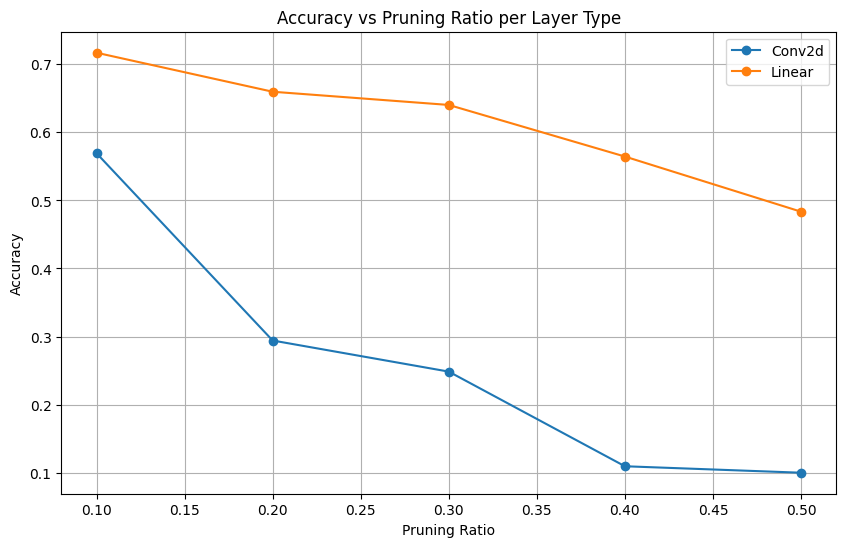

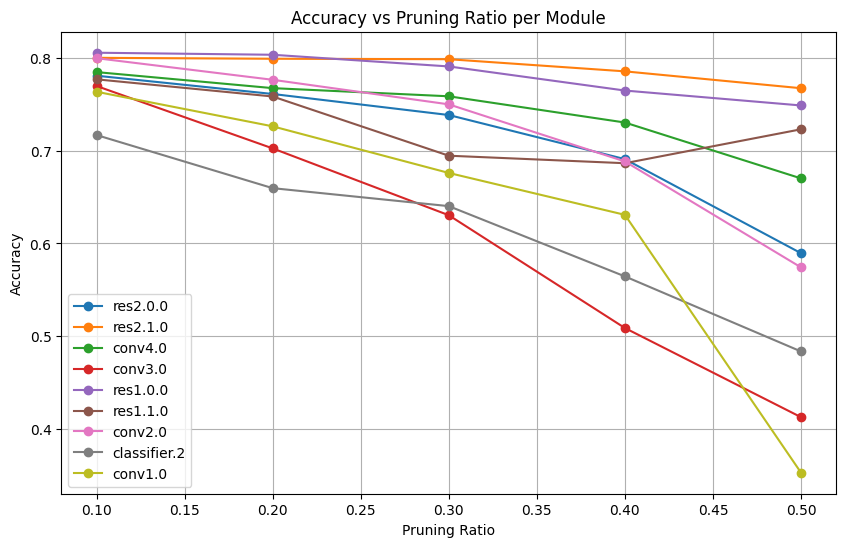

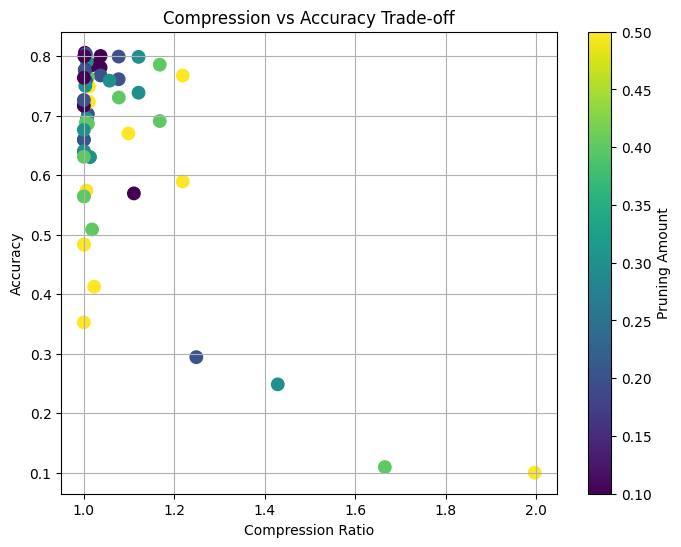

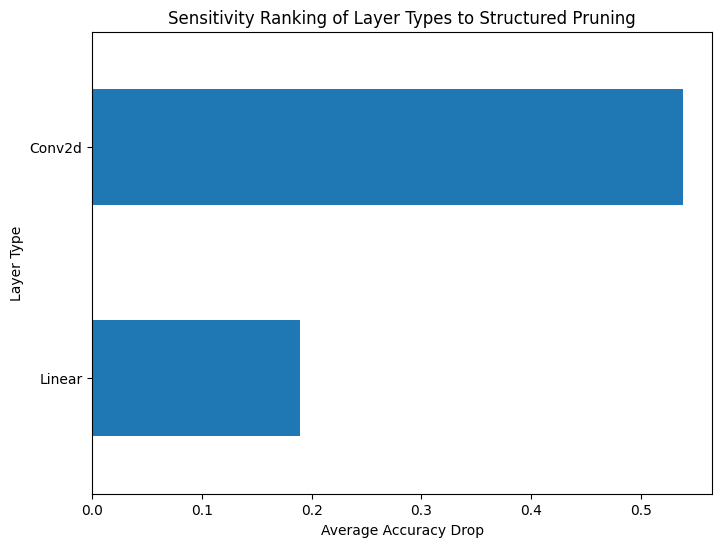

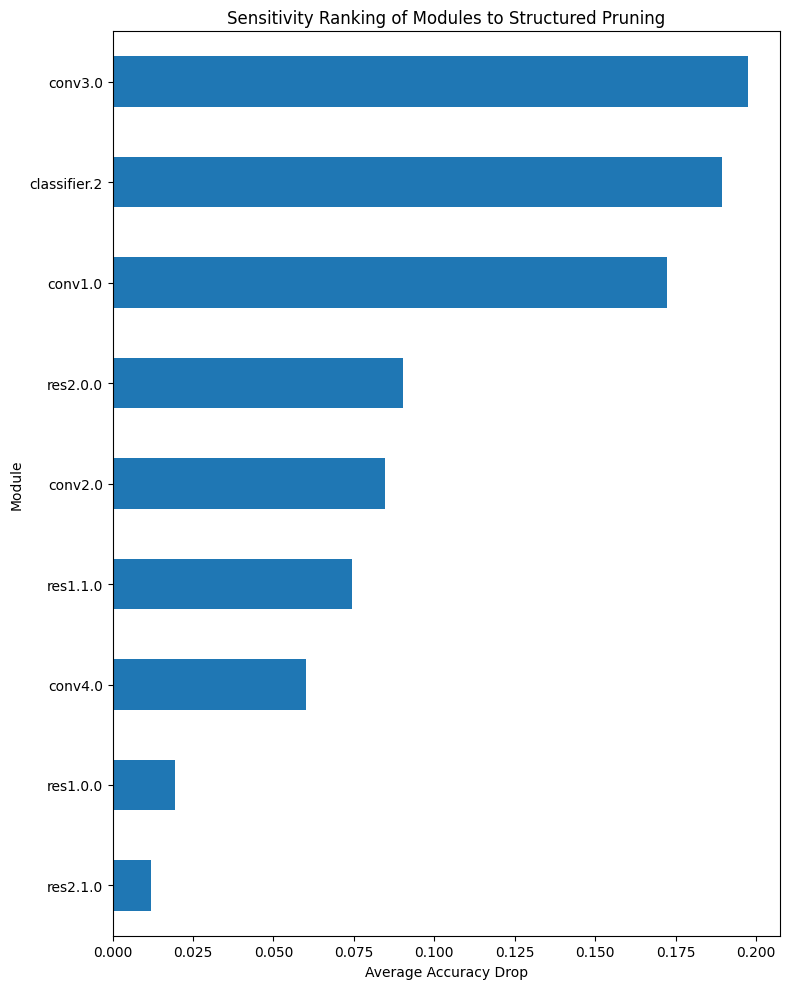

Summary Table:


,pruning_level,module_or_layer_type,amount,pruned_params,remaining_params,compression_ratio,sparsity(%),accuracy
0,layer_type,Conv2d,0.1,655074,5920296.0,1.110649,9.962542,0.5693
1,layer_type,Conv2d,0.2,1309023,5266347.0,1.248564,19.907975,0.2942
2,layer_type,Conv2d,0.3,1972737,4602633.0,1.428611,30.001916,0.2485
3,layer_type,Conv2d,0.4,2626686,3948684.0,1.665205,39.947349,0.1095
4,layer_type,Conv2d,0.5,3281760,3293610.0,1.996402,49.909891,0.1000
5,layer_type,Linear,0.1,512,6574858.0,1.000078,0.007787,0.7169
6,layer_type,Linear,0.2,1024,6574346.0,1.000156,0.015573,0.6596
7,layer_type,Linear,0.3,1536,6573834.0,1.000234,0.023360,0.6402
8,layer_type,Linear,0.4,2048,6573322.0,1.000312,0.031147,0.5644
9,layer_type,Linear,0.5,2560,6572810.0,1.000389,0.038933,0.4834


In [ ]:
# Accuracy vs Pruning Ratio per module type
layer_type_df = df[df["pruning_level"] == "layer_type"]
plt.figure(figsize=(10, 6))
for layer_type in layer_type_df["module_or_layer_type"].unique():
    subset = layer_type_df[layer_type_df["module_or_layer_type"] == layer_type]
    plt.plot(subset["amount"], subset["accuracy"], marker="o", label=layer_type)
plt.xlabel("Pruning Ratio")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Pruning Ratio per Layer Type")
plt.legend()
plt.grid(True)
plt.show()

# Accuracy vs Pruning Ratio per module
module_df = df[df["pruning_level"] == "module"]
plt.figure(figsize=(10, 6))
for module in module_df["module_or_layer_type"].unique():
    subset = module_df[module_df["module_or_layer_type"] == module]
    plt.plot(subset["amount"], subset["accuracy"], marker="o", label=module)
plt.xlabel("Pruning Ratio")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Pruning Ratio per Module")
plt.legend()
plt.grid(True)
plt.show()

# Compression vs Accuracy tradeoff
plt.figure(figsize=(8, 6))
plt.scatter(df["compression_ratio"], df["accuracy"], c=df["amount"], cmap="viridis", s=80)
plt.colorbar(label="Pruning Amount")
plt.xlabel("Compression Ratio")
plt.ylabel("Accuracy")
plt.title("Compression vs Accuracy Trade-off")
plt.grid(True)
plt.show()

# Sensitivity ranking: avg accuracy drop per module
# Calculate baseline accuracy from the original model (no pruning)
baseline_acc = test_acc
# baseline_acc = df[(df["pruning_level"] == "layer_type") & (df["amount"] == 0.1)]["accuracy"].max() # Or use the accuracy of the unpruned model if available in df
df["acc_drop"] = baseline_acc - df["accuracy"]

# Separate sensitivity for layer types and modules
layer_type_sensitivity = df[df["pruning_level"] == "layer_type"].groupby("module_or_layer_type")["acc_drop"].mean().sort_values()
module_sensitivity = df[df["pruning_level"] == "module"].groupby("module_or_layer_type")["acc_drop"].mean().sort_values()


plt.figure(figsize=(8, 6))
layer_type_sensitivity.plot(kind="barh")
plt.xlabel("Average Accuracy Drop")
plt.ylabel("Layer Type")
plt.title("Sensitivity Ranking of Layer Types to Structured Pruning")
plt.show()

plt.figure(figsize=(8, 10)) # Adjusted figure size for better readability with more modules
module_sensitivity.plot(kind="barh")
plt.xlabel("Average Accuracy Drop")
plt.ylabel("Module")
plt.title("Sensitivity Ranking of Modules to Structured Pruning")
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()


# ----------------------
# 4. Summary tables
# ----------------------

summary = df.groupby(["pruning_level", "module_or_layer_type", "amount"]).agg({
    "pruned_params": "sum",
    "remaining_params": "mean",
    "compression_ratio": "mean",
    "sparsity(%)": "mean",
    "accuracy": "mean"
}).reset_index()

print("Summary Table:")
display(summary)

### [10%] Part d: Explaining Pruning

#### [5%] Pruning Sensitivity Analysis and Hypothesis

Based on your module-wise pruning experiments and results, analyze the patterns you observed:

**Note:** You should conduct pruning sensitivity experiments across different **module types** (e.g., attention layers, MLP blocks, residual connections).

Use your findings to support the following analyses:

1. **Module Robustness Hypothesis**:
   - Examine your pruning sensitivity graphs for different **module types**.
   - Identify which modules were most or least robust to pruning.
   - Hypothesize why certain modules tolerate more pruning (e.g., feature complexity, redundancy, gradient flow, or functional role).

2. **Progressive Pruning Trends**:
   - Describe how sensitivity patterns change with increasing pruning ratios.
   - Identify any non-linear trends or abrupt drops in performance.
   - Interpret these effects in terms of capacity, redundancy, or structural importance.

3. **Module-Specific Observations**:
   - Highlight differences in pruning sensitivity across module types.
   - Discuss how components like residual connections influence pruning robustness.
   - Comment on any notable behavior of auxiliary modules such as normalization layers.

**[Answer]:** *(Provide your analysis here based on your experimental results)*


---

#### [5%] Alternative Pruning Metrics

While this exercise used L2 norm for pruning decisions, many other importance metrics exist. List **5 creative pruning metrics** beyond simple L_p norms:

**Reference**: You may explore the [Torch Pruning library](https://github.com/VainF/Torch-Pruning) documentation for inspiration, but provide original explanations.

**Required Format**: For each metric, provide:
- Metric name and brief description
- Intuition for why it might be effective
- Potential advantages/disadvantages

**Example Metrics to Explore:**
- Gradient-based importance measures
- Activation-based metrics
- Information-theoretic approaches
- Network connectivity measures
- Task-specific importance scores

---

#### [2%] Bonus: Pruning vs. Quantization Trade-offs

Both pruning and quantization reduce model size, but through different mechanisms. Analyze when each approach is preferable:

**Required Analysis:**

1. **When Pruning is Better**:
  - Identify scenarios where removing parameters entirely is more beneficial than reducing precision
  - Consider hardware constraints, inference patterns, and model architectures
  - Discuss memory vs. computational trade-offs

2. **When Quantization is Better**:
  - Explain situations where reducing bit precision is more effective than removing parameters
  - Consider deployment constraints and hardware acceleration
  - Discuss preservation of model capacity vs. efficiency gains

3. **Hybrid Approaches**:
  - Describe scenarios where combining both techniques might be optimal
  - Consider the order of application (prune-then-quantize vs. quantize-then-prune)

**Note**: There is no single correct answer. Provide thoughtful analysis based on different use cases, hardware constraints, and performance requirements.

---

## Pruning Sensitivity Analysis


1.   **Module Robustness Hypothesis**
  - We observe that the modules `conv1`, `conv3` and `classifier2` are the most sensitive and significantly more sensitive to other layers if we consult the sensitivity analysis graph.
    - `conv1`: This is the first convolutional layer and potentially captures lower-level details about the image such as edges or general gradient information. Hence, when you prune this layer it affects the performance significantly
    - `conv3`: If we look at the structure of the model, this sort of acts like an "information bottleneck" for passing information from the first residual block to the next. Hence, pruning this might affect the passing of important information.
    - `classifier.2`: Since  this is the final classifier which takes a 512 dim vector and predicts the output, pruning this would have a very direct impact on the output. Hence, this layer might be quite sensitive to pruning

2.   **Sensitivity Patterns**
  - **Initial Resillience (Up to 0.3 pruning ratio)**: Initially, most modules are highly resilient, showing only a slight decline in accuracy. This demonstrates parameter redundancy; the model has enough excess capacity that removing these early weights has little effect on performance because other weights compensate.
  - **Abrupt Performance Drop (Between 0.3 and 0.4)**: Highly sensitive (and by extension, important) layers like `conv1`, `conv3` and `classifier.2` show a big drop in accuracy which is non-linear with the trend that was being followed early.
  - **Later Stages (0.4 to 0.5)**: For these pruning ratios almost all the layers show a significant decline in the model accuracy

3. **Module-wise analysis**
  - We see that residual blocks are way more robust than layers like `conv1` or `conv3` which serve as important feature extractors or information bottlenecks.
  - The residual blocks are significantly more robust because they can be formulated as $out = \text{res}(out) + out$ so even if all the weights are pruned, information is still able to go through the
  - **Behaviour of auxillary modules:** When we prune the convolutional layers around the batch-norm layer, the statistics (mean/variance) around it changing. This can lead to a shift in the distribution which could harm performance, so even if we are not pruning any batchnorm params, it's performance ends up getting harmed

  ## Alternative Metrics
  1. Mutual Information Based:
      - **Description**: Measures the mutual information between a neuron’s (or channel’s) activations and the target labels. Neurons with low MI contribute little to predicting the task and are candidates for pruning.
      - **Intuition**: A neuron or layer that carries least information about a label is not contributing much to the output of the model
      - **Advantages**: It is tied directly to the task instead of depending on proxies like the activation of a weight. It could be the case that there are large weights but don't end up actually contributing much to the final result.
      - **Disadvantages**: This could be quite computationally intensive, especially because there could be continuos activations like ReLU and sigmoid that would require discretization
  
2. Gradient-Weighted Magnitude:
    - **Description**: Score a parameter by  $w ⋅ |\nabla \mathcal{L}(w)|$, combining its magnitude with the gradient of the loss.  
    - **Intuition**: Parameters with large gradients strongly influence the loss, even if their raw weights are small.  
    - **Advantages**: Captures task sensitivity rather than just static size.  
    - **Disadvantages**: Requires gradients, so it’s more computationally expensive.  

3. Connectivity Centrality
    - **Description**: Measure how connected a neuron/channel is, e.g., by the number and strength of its input/output edges.  
    - **Intuition**: Nodes that are more connected in the computation graph are more structurally important since they influence more neurons
    - **Advantages**: Structure-aware about the model and prevents us from pruning potential information bottlenecks
    - **Disadvantages**: Assumes that all highly connected neurons are important to the task at hand

4. Activation Sparsity
    - **Description**: Score a neuron/channel by how often its activations are close to zero across a dataset.  
    - **Intuition**: Neurons that rarely activate contribute little to representation.  
    - **Advantages**: Easy to measure; naturally identifies “dead” or unused units.  
    - **Disadvantages**: Dataset-dependent; may prune units that are rarely used but still important so we might have the model perform poorly on certain classes in case of an imbalanced dataset

5. Validation Drop Score
    - **Description**: Temporarily mask a neuron/channel and measure the drop in validation accuracy or increase in loss.  
    - **Intuition**: Directly tests how much the model relies on a component.  
    - **Advantages**: This optimizes directly for the task and is straightforward to interpret
    - **Disadvantages**: This is quite expensive since we need to have multiple forward passes just to compute the masking

## Pruning vs. Quantization Trade-offs
1. **When Pruning might be better**:
- There is a need for reduced number of parameters because of memory limitations on a device
- We have architecture that can handle sparse computation
- There are structured blocks in your model that could be pruned as a whole module without affecting performance by a lot

2. **When quantization might be better**:
- When we have compute that can perform better on dense matrices
- We have compute that has efficient low-precision (INT8, FP16) compute
- You dont want to fine-tune the model again, so you can train with quantization-aware training (QAT)

3. **Hybrid Approach**:
- A hybrid approach could possibly be needed in cases where extreme compression is required, maybe for something like deployment on IoT. Here we might find it helpful to use structured pruning instead of unstructured since the hardware here might not handle sparse operations very well.
    - `prune-then-quantize`: I feel like most use-cases I can think of fit well with this methodology because when one quantizes after pruning, there is less amount of quantization noise since the number of parameters also reduces. You don't want quantization noise introduced by neurons or blocks that you are going to discard after pruning anyway.
    - `quantize-then-prune`: Personally, it was not intuitive to me the reason behind pruning after quantizing. This could be a useful tool if you are not able to fine-tune your model and want to reduce size.